In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import cv2
import os
import random
import numpy as np
import pandas as pd
import torchvision.datasets
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import copy
import datetime as dt
import random
import torchvision

from functools import partial
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
pip install torchsummary 

Note: you may need to restart the kernel to use updated packages.


In [5]:
def read_data(n_false=0, n_true=0, mode = 'train'):
    
    if mode == 'train':   # Если не указывать количество изображений для считывания, автоматически установится 
        if not n_false:   # макисмальное значение
            n_false = 9892
        if not n_true:
            n_true = 13300
            
        false_path = '/kaggle/input/train-data/train/false/'
        true_path = '/kaggle/input/train-data/train/true/'
    
    if mode == 'val':
        if not n_false:   
            n_false = 1531
        if not n_true:
            n_true = 1515
            
        false_path = '/kaggle/input/validation/validation/valid_false/'
        true_path = '/kaggle/input/validation/validation/valid_true/'
        
    elif mode == 'test':
        if not n_false:
            n_false = 438
        if not n_true:
            n_true = 433
            
        false_path = '/kaggle/input/tanks-test/test1/test1/false/'
        true_path = '/kaggle/input/tanks-test/test1/test1/true/'
    
    data = torch.empty(size=[n_false + n_true, 144, 256, 3], dtype=torch.uint8)
    
    k = 0
    for dirname, _, filenames in os.walk(false_path): # Cчитывание false изображений
        for i, filename in enumerate(filenames):       
            data[i] = torch.tensor(cv2.imread(os.path.join(dirname, filename)), dtype=torch.uint8)
            k += 1
            if k == n_false:
                break
                
    k = 0
    for dirname, _, filenames in os.walk(true_path):   # Cчитывание true изображений
        for i, filename in enumerate(filenames):
            data[i + n_false] = torch.tensor(cv2.imread(os.path.join(dirname, filename)), dtype=torch.uint8)
            k += 1
            if k == n_true:
                break
                
    data_perm = data.to(device).permute(0, 3, 1, 2)  # Приведение к формату channels first
    
    # Генерация меток, первая часть - нули, вторая - единицы
    labels = torch.cat((torch.zeros(size=[n_true], dtype=int), torch.ones(size=[n_false], dtype=int))) 

    if mode == 'test':
        tanks_labeled = [data_perm, labels] # Для теста нет необходимости в перемешивании
           
    else:
        idx = torch.randperm(labels.shape[0]) # Индексы перемешанных меток
        tanks_labeled = [data_perm[idx], labels[idx]] # Одинаково перемешанные данные и метки кладём в список
    
    return tanks_labeled

In [6]:
%%time
train_data = read_data(n_false = 10600, n_true = 11400, mode = 'train')

CPU times: user 18.3 s, sys: 4.91 s, total: 23.2 s
Wall time: 2min 44s


Метка: 1


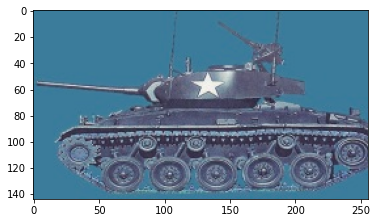

In [7]:
print('Метка:', int(train_data[1][479]))
plt.imshow(train_data[0].cpu()[479].permute(1, 2, 0))

Метка: 1
CPU times: user 704 ms, sys: 227 ms, total: 931 ms
Wall time: 6.19 s


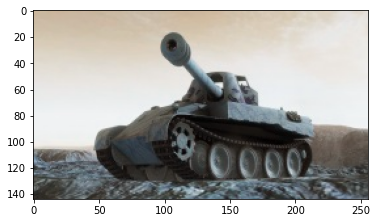

In [8]:
%%time
test_data = read_data(mode = 'test')
print('Метка:', int(test_data[1][479]))
plt.imshow(test_data[0].cpu()[479].permute(1, 2, 0))

Метка: 0
CPU times: user 2.53 s, sys: 782 ms, total: 3.31 s
Wall time: 22.6 s


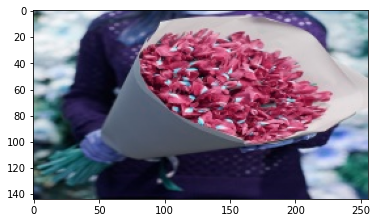

In [9]:
%%time  
# Изображения в валидационном датасете были подобраны более тщательно, чтобы их распределение совпадало с 
# изображениями из тестового датасета.
val_data = read_data(mode = 'val') 
print('Метка:', int(val_data[1][0]))
plt.imshow(val_data[0].cpu()[0].permute(1, 2, 0))

In [10]:
print('train shape:', len(train_data[0]), 'val shape:', len(val_data[0]))

train shape: 22000 val shape: 3046


In [11]:
# Класс для чтения изображений по бачам, во время обучения. Избавляет от необходимости хранить весь обучающий
# набор в оперативной памяти. Однако, из-за низкой скорости чтения жёсткого диска на платформе Kaggle 
# не имеет смысла. 

# class CustomImageDataset(Dataset):
#     def __init__(self, path, transform=None, target_transform=None):
#         self.path = path

#     def __len__(self):
#         return len(self.path)

#     def __getitem__(self, idx):
#         img_path = self.path[idx][0]
#         image = torch.Tensor(cv2.imread(img_path)).permute(2, 0, 1).to(device)/255
#         label = self.path[idx][1]
        
#         return image, label

In [12]:
class MyDataset(Dataset):
  
    def __init__(self, list_data):
        if len(list_data) == 2: # на вход принимает list object, где list[0] - изображения, list[1] - метки.
            self.X = list_data[0]/255 
            self.y = list_data[1] 
        else:                   # если подать только тензор изображений, self.y не будет иметь смысла
            self.X = list_data/255       
            self.y = ['отсутствует' for i in range(len(list_data))] 
            
    def __len__(self):
        return self.X.shape[0]
  
    def __getitem__(self, index):
        return (self.X[index].unsqueeze(0), self.y[index])

In [13]:
BATCH_SIZE = 32

# create Dataset
train_dataset = MyDataset(train_data)
val_dataset = MyDataset(val_data)

# create Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
def plot_eval(train_loss, train_accuracy, val_loss, val_accuracy): # Рисует графики loss и accuracy
    
    d = {'train_loss' : train_loss,
         'val_loss' : val_loss,
         'train_accuracy' : train_accuracy,
         'val_accuracy' : val_accuracy}
    
    df_loss_acc = pd.DataFrame(d)
    df_loss= df_loss_acc[['train_loss','val_loss']]
    df_loss.rename(columns={'train_loss':'train','val_loss':'validation'},inplace=True)
    df_acc= df_loss_acc[['train_accuracy','val_accuracy']]
    df_acc.rename(columns={'train_accuracy':'train','val_accuracy':'validation'},inplace=True)
    
    fig, axes = plt.subplots(nrows=1, ncols=2)

    df_loss.plot(ax=axes[0], title='Model loss',figsize=(16,5)).set(xlabel='Epoch',ylabel='Loss')
    df_acc.plot(ax=axes[1], title='Model Accuracy',figsize=(16,5)).set(xlabel='Epoch',ylabel='Accuracy')

In [15]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3))
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=2)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, padding=1)
        self.drop1 = nn.Dropout(0.2)
        self.bn1 = nn.BatchNorm2d(num_features=16)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3))
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=2)
        self.relu4 = nn.ReLU()
        self.drop2 = nn.Dropout(0.5)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.fc1 = nn.Linear(64416, 256)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(256, 10) 
        
    def forward(self, x):
        #print(x.shape)
        out = self.conv1(x)
        out = self.relu1(out)
        #print(out.shape)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.drop1(out)
        out = self.bn1(out)
        #print(out.shape)
        out = self.conv3(out)
        out = self.relu3(out)
        #print(out.shape)
        out = self.conv4(out)
        out = self.relu4(out)
        out = self.drop2(out)
        #print(out.shape)
        out = self.bn2(out)
        #print(out.shape)
        out = out.view(out.size(0), out.size(1) * out.size(2) * out.size(3))
        #print(out.shape)
        out = self.fc1(out)
        out = self.relu5(out)
        out = self.fc2(out)
        
        return out

In [16]:
class Trainer():
    """
    Parameters:
        dataset: пользовательский класс, предобрабатывающий данные
        loss_f: функция потерь
        learning_rate: величина градиентного шага
        epoch_amount: общее количество эпох
        batch_size: размер одного бача
        max_batches_per_epoch: максимальное количество бачей, 
                               подаваемых в модель в одну эпоху
        device: устройство для вычислений
        early_stopping: количество эпох без улучшений до остановки обучения
        optim: оптимизатор
        scheduler: регулятор градиентного шага
        permutate: перемешивание тренировочной выборки перед обучением

    Attributes:
        start_model: необученная модель
        best_model: модель, после обучения
        train_loss: средние значения функции потерь на тренировочных 
                    данных в каждой эпохе
        val_loss: средние значения функции потерь на валидационных 
                  данных в каждой эпохе

    Methods:
        fit: обучение модели
        predict: возвращает предсказание обученной моделью

    """
    def __init__(self,  dataset, net, loss_f, learning_rate=1e-3, 
                epoch_amount=10, batch_size=12, 
                max_batches_per_epoch=None,
                device='cpu', early_stopping=10, 
                optim=torch.optim.Adam, 
                scheduler=torch.optim.lr_scheduler.ExponentialLR, permutate=True):
        
        self.loss_f = loss_f
        self.learning_rate = learning_rate
        self.epoch_amount = epoch_amount
        self.batch_size = batch_size
        self.max_batches_per_epoch = max_batches_per_epoch
        self.device = device
        self.early_stopping = early_stopping
        self.optim = optim
        self.scheduler = scheduler
        self.permutate = permutate
        self.dataset = dataset
        self.start_model = net
        self.best_model = net

        self.train_loss = []
        self.train_accuracy = []
        self.val_loss = []
        self.val_accuracy = []
        
        #self.test_accyracy = []
        
    def predict(self, X):
        return self.best_model(X)

    def fit(self, train, val): # train_dataloader и val_dataloader

        Net = self.start_model
            
        device = torch.device(self.device)

        Net.to(self.device)

        optimizer = self.optim(Net.parameters(), lr=self.learning_rate, weight_decay=0.001)
        
        if self.scheduler is not None:
            scheduler = self.scheduler(optimizer, gamma=0.98, verbose=True)

        best_val_loss = float('inf') # Лучшее значение функции потерь на валидационной выборке
                                     # функции потерь на валидационной выборке
        best_ep = 0                  # Эпоха, на которой достигалось лучшее 
                                     # значение функции потерь на валидационной выборке
            
        for epoch in range(self.epoch_amount): 
            
            start = dt.datetime.now()
            print(f'Эпоха: {epoch}', end=' ')
            Net.train()
            mean_loss = 0
            batch_n = 0
            
            train_pred = torch.tensor((), device=device)
            train_target = torch.tensor((), device=device)
            
            for batch_X, target in train:
                if self.max_batches_per_epoch is not None:
                    if batch_n >= self.max_batches_per_epoch:
                        break
                optimizer.zero_grad()
                    
                batch_X = batch_X.to(self.device).float()
                target = target.to(self.device)
                
                predicted_values = Net(batch_X.squeeze(1))
                
                train_pred = torch.cat((train_pred, predicted_values), 0)
                train_target = torch.cat((train_target, target), 0)

                loss = self.loss_f(predicted_values, target)
                loss.backward()
                optimizer.step()

                mean_loss += float(loss)
                batch_n += 1       
           
            mean_loss /= batch_n
            self.train_loss.append(mean_loss)
            print(f'Loss_train: {mean_loss}, {dt.datetime.now() - start} сек')
                      
            Net.eval()
            
            mean_loss = 0
            batch_n = 0

            val_pred = torch.tensor(()).to(device)
            val_target = torch.tensor(()).to(device)
            
            with torch.no_grad():
                for batch_X, target in val:
                    if self.max_batches_per_epoch is not None:
                        if batch_n >= self.max_batches_per_epoch:
                            break
                    batch_X = batch_X.to(self.device).float()
                    target = target.to(self.device)

                    predicted_values = Net(batch_X.squeeze(1))
                
                    val_pred = torch.cat((val_pred, predicted_values), 0)
                    val_target = torch.cat((val_target, target), 0)

                    loss = self.loss_f(predicted_values, target)                
                    mean_loss += float(loss)
                    batch_n += 1
                
            mean_loss /= batch_n
            self.val_loss.append(mean_loss)
            print(f'Loss_val: {mean_loss}')

            train_epoch_accuracy = (train_pred.argmax(dim=1) == train_target).float().mean().data.cpu()
            self.train_accuracy.append(train_epoch_accuracy.item())
            print('Accuracy train', train_epoch_accuracy.item())
            
            val_epoch_accuracy = (val_pred.argmax(dim=1) == val_target).float().mean().data.cpu()
            self.val_accuracy.append(val_epoch_accuracy.item())
            print('Accuracy val', val_epoch_accuracy.item())
            
            
            
            if mean_loss < best_val_loss:
                self.best_model = Net
                best_val_loss = mean_loss
                best_ep = epoch
            elif epoch - best_ep > self.early_stopping:
                print(f'{self.early_stopping} без улучшений. Прекращаем обучение...')
                break
            if self.scheduler is not None:
                scheduler.step()
            print()

In [17]:
net = CNN().to(device)
print(net)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
  (relu2): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
  (relu4): ReLU()
  (drop2): Dropout(p=0.5, inplace=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=64416, out_features=256, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [18]:
#net = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False).to(device)
net = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=False).to(device)
#net = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False).to(device)
# net = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=False).to(device)
#net = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=False).to(device)
#print(net)
net.fc = nn.Linear(512, 2).to(device)
from torchsummary import summary
summary(net, (3, 144, 256))

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 72, 128]           9,408
       BatchNorm2d-2          [-1, 64, 72, 128]             128
              ReLU-3          [-1, 64, 72, 128]               0
         MaxPool2d-4           [-1, 64, 36, 64]               0
            Conv2d-5           [-1, 64, 36, 64]          36,864
       BatchNorm2d-6           [-1, 64, 36, 64]             128
              ReLU-7           [-1, 64, 36, 64]               0
            Conv2d-8           [-1, 64, 36, 64]          36,864
       BatchNorm2d-9           [-1, 64, 36, 64]             128
             ReLU-10           [-1, 64, 36, 64]               0
       BasicBlock-11           [-1, 64, 36, 64]               0
           Conv2d-12           [-1, 64, 36, 64]          36,864
      BatchNorm2d-13           [-1, 64, 36, 64]             128
             ReLU-14           [-1, 64,

In [19]:
params = {
    'dataset': MyDataset,
    'net': net,
    'epoch_amount': 200, 
    'learning_rate': 1e-3,
    'early_stopping': 35,
    #'scheduler': torch.optim.lr_scheduler.ExponentialLR(torch.optim.Adam, 0.9),
    'loss_f': nn.CrossEntropyLoss(),
    'device' : torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
}

clf = Trainer(**params)
clf.fit(train_dataloader, val_dataloader)

Adjusting learning rate of group 0 to 1.0000e-03.
Эпоха: 0 Loss_train: 0.5870781014565118, 0:01:31.151850 сек
Loss_val: 0.5072484649717808
Accuracy train 0.710772693157196
Accuracy val 0.7767564058303833
Adjusting learning rate of group 0 to 9.8000e-04.

Эпоха: 1 Loss_train: 0.5275143270359136, 0:01:31.028335 сек
Loss_val: 0.5597363688672582
Accuracy train 0.7508636116981506
Accuracy val 0.7655942440032959
Adjusting learning rate of group 0 to 9.6040e-04.

Эпоха: 2 Loss_train: 0.4943295465132525, 0:01:31.034321 сек
Loss_val: 0.41291758976876736
Accuracy train 0.770727276802063
Accuracy val 0.8351936936378479
Adjusting learning rate of group 0 to 9.4119e-04.

Эпоха: 3 Loss_train: 0.46677663116607554, 0:01:30.993106 сек
Loss_val: 0.3770498496790727
Accuracy train 0.7904545068740845
Accuracy val 0.8417596817016602
Adjusting learning rate of group 0 to 9.2237e-04.

Эпоха: 4 Loss_train: 0.4445582659005426, 0:01:30.994170 сек
Loss_val: 0.35111381439492106
Accuracy train 0.8056363463401794
Ac

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


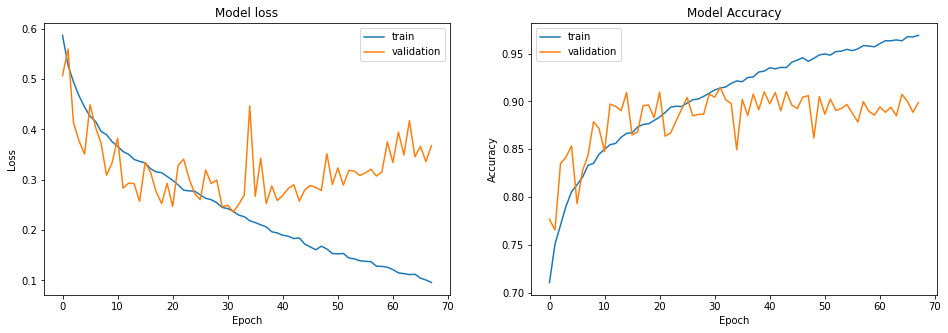

In [20]:
plot_eval(clf.train_loss, clf.train_accuracy, clf.val_loss, clf.val_accuracy)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


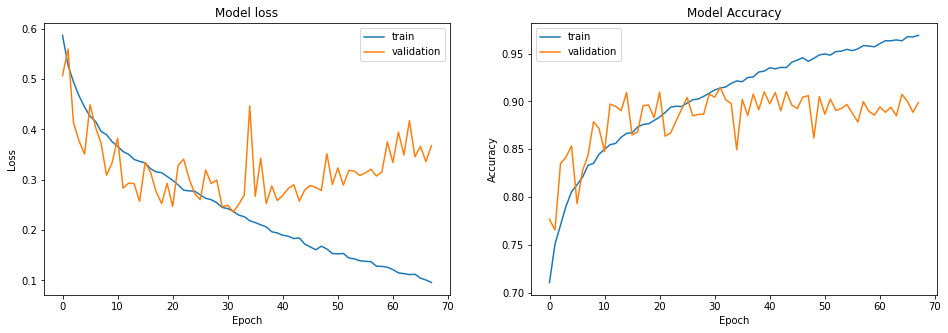

In [21]:
plot_eval(clf.train_loss, clf.train_accuracy, clf.val_loss, clf.val_accuracy)

In [22]:
test_dataset = MyDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

val_pred = torch.tensor(()).to(device)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

with torch.no_grad():
    for batch_X, t in test_dataloader:

        batch_X = batch_X.float().to(device)

        predicted_values = clf.predict(batch_X.squeeze(1))
    
        val_pred = torch.cat((val_pred, predicted_values), 0)

from sklearn.metrics import accuracy_score
ans = val_pred.argmax(dim=1)
acc = accuracy_score(test_data[1].numpy(), ans.cpu().numpy())
acc

0.928817451205511

In [23]:
ans

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [24]:
val_accuracy = []
val_pred = torch.tensor(()).to(device)
val_target = torch.tensor(()).to(device)

val_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
clf.best_model.eval()
with torch.no_grad():
    for batch_X, target in val_dataloader:
        
        batch_X = batch_X.to(device).float()
        target = target.to(device)
        
        predicted_values = clf.best_model(batch_X.squeeze(1))
                
        val_pred = torch.cat((val_pred, predicted_values), 0)
        val_target = torch.cat((val_target, target), 0)
                     
val_epoch_accuracy = (val_pred.argmax(dim=1) == val_target).float().mean().data.cpu()
print('Accuracy val', val_epoch_accuracy.item())

Accuracy val 0.9288174510002136
